# Import Module

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error


# Stock data

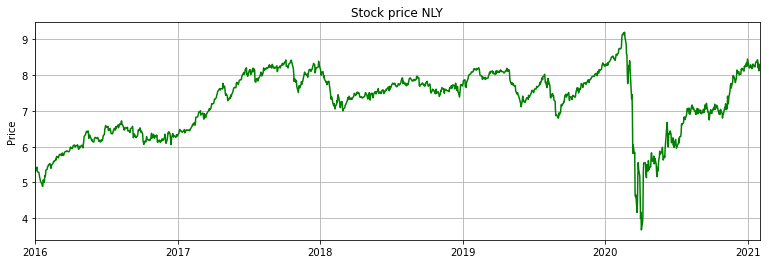

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1280 entries, 2015-12-31 to 2021-02-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1280 non-null   float64
 1   Low        1280 non-null   float64
 2   Open       1280 non-null   float64
 3   Close      1280 non-null   float64
 4   Volume     1280 non-null   float64
 5   Adj Close  1280 non-null   float64
dtypes: float64(6)
memory usage: 70.0 KB


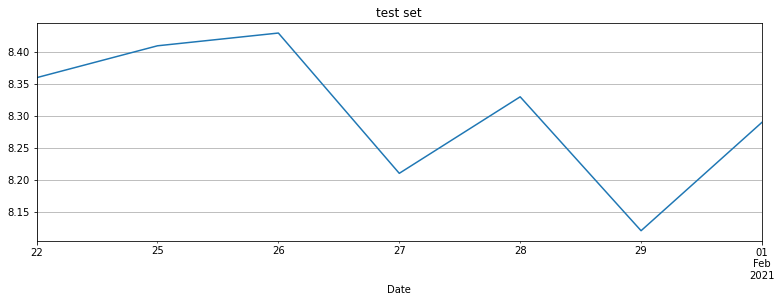

In [2]:
ticker = 'nly'.upper()
df = web.DataReader(ticker, 'yahoo', '2016-01-01', '2021-02-01')
plt.figure(figsize=(13,4))
plt.title('Stock price '+ ticker)
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Adj Close'], color='g')
plt.show()

y = df['Adj Close'].values.astype(float)

test_size = 7
window_size = 120
train_set = y[:-test_size]
test_set = y[-test_size:]
df.info()

df['Adj Close'].iloc[-test_size:].plot(figsize=(13,4))
plt.title('test set')
plt.grid(True)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set.reshape(-1, 1))

# Recurrent Neural Network

In [3]:
class RecurrentNetwork:
    def __init__(self,
                 data,
                 test_size,
                 ticker,
                 future,
                 window_size=120,
                 layers=[50, 50, 50, 50, 50, 50],
                 dropout=0.2,
                 epochs=150,
                 batch_size=32):
        
        self.df = data
        self.layers = layers
        self.ticker = ticker
        self.dropout = dropout
        self.window_size = window_size
        self.test_size = test_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.future = future
        self.true_predictions = None
        
        self.train_set, self.test_set = self.spilt_data()
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.train_norm, self.test_norm = self.norm_data()
        self.X_train, self.y_train = self.input_label()
        self.X_test, self.y_test = self.val_data()
        
        
        self.seeding(seed=101)
        self.model = self.build_model_rnn()
        
        
    def __str__(self):
        return str(self.model.summary())
    

    
        
    def seeding(self, seed):
        return np.random.seed(seed)
    
    
    def spilt_data(self):
        y = self.df['Adj Close'].values.astype(float)
        train_set = y[:-self.test_size]
        test_set = y[-self.test_size:]
        
        return train_set, test_set
    
    
    def norm_data(self):
        train_norm = scaler.transform(self.train_set.reshape(-1, 1))
        test_norm = scaler.transform(self.test_set.reshape(-1, 1))
        return train_norm, test_norm
    
    
    def input_label(self):
        X_train = []
        y_train = []
        for i in range(self.window_size, len(self.train_norm)):
            X_train.append(self.train_norm[i-self.window_size:i,0])
            y_train.append(self.train_norm[i,0])

        X_train,y_train = np.array(X_train), np.array(y_train) 
        
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        
        return X_train,y_train
    
    
    def val_data(self):
        X_test = []
        y_test = []

        seq = self.train_norm[-(self.window_size-1):]

        for i in range(len(self.test_norm)):

            seq = np.array(seq[-(self.window_size-1):], dtype=np.float32)

            seq = np.append(seq, self.test_norm[i])

            X_test.append(seq)
            y_test.append(self.test_norm[i])

        X_test,y_test = np.array(X_test), np.array(y_test) 
        
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        return X_test,y_test
        
    
    
    def build_model_rnn(self):
        
        model = Sequential()

        
        for i in range(len(self.layers)):
            if i == 0:
                model.add(LSTM(units=self.layers[i], return_sequences=True, input_shape=(self.X_train.shape[1], 1)))
                model.add(Dropout(self.dropout))
                
            elif i == (len(self.layers) - 1):
                model.add(LSTM(units=self.layers[i],))
                model.add(Dropout(self.dropout))
                
            else:
                model.add(LSTM(units=self.layers[i], return_sequences=True))
                model.add(Dropout(self.dropout))
                

        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')
    
        
        return model
    
    
    def training(self):
        
        self.model.fit(self.X_train,
                       self.y_train,
                       epochs=self.epochs,
                       validation_data=(self.X_test, self.y_test),
                       batch_size=self.batch_size)
        
        self.save()
        
        
    def loss_render(self):
        losses = pd.DataFrame(self.model.history.history)
        losses[['loss', 'val_loss']].plot(figsize=(6,10), label='Loss', subplots=True);
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        
        
    def save(self):
        
        self.model.save_weights(f'model/{self.ticker}.h5')
        print('Saved model!!')
        
    
    def load(self):
        self.model.load_weights(f'model/{self.ticker}.h5')
        print('Loading model complete!!')
        
        
    
    def testing(self):
        self.load()
        
        preds = self.train_norm[-self.window_size:].tolist()
        
        for i in range(self.future):
            seq = np.array(preds[-self.window_size:], dtype=np.float32)
            seq = np.reshape(seq, (seq.shape[1], seq.shape[0], 1))
            predict = self.model.predict(seq)
            preds.append(predict)

        self.true_predictions = scaler.inverse_transform(np.array(preds[self.window_size:]).reshape(-1, 1))
        df1 = pd.DataFrame(self.true_predictions, index=df.tail(self.future).index, columns=['pred'])


        plt.figure(figsize=(12,4))
        plt.grid(True)
        plt.autoscale(axis='x',tight=True)
        plt.plot(self.df['Adj Close'].iloc[-(self.future + 10):], label='Stock price')
        plt.plot(df1['pred'], label='predicted')
        plt.title('Prediction')
        plt.xlabel('Date')
        plt.legend()
        
        
    def amse(self):
        return np.sqrt(mean_squared_error(self.true_predictions.reshape(1, -1), self.df['Adj Close'][-7:].values.reshape(1, -1)))
        
        
        
        
        
        
        

# Config

In [4]:
model = RecurrentNetwork(data=df,
                         test_size=7,
                         ticker=ticker,
                         future=7,
                         layers=[100]*6,
                         window_size=120,
                         dropout=0.2,
                         epochs=150,
                         batch_size=32)

# Model

In [5]:
print(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 120, 100)          80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120, 100)          8

# Training

In [6]:
model.training()

Epoch 1/150
37/37 [==============================] - 13s 350ms/step - loss: 0.0454 - val_loss: 0.0301
Epoch 2/150
37/37 [==============================] - 11s 310ms/step - loss: 0.0218 - val_loss: 0.0202
Epoch 3/150
37/37 [==============================] - 12s 323ms/step - loss: 0.0118 - val_loss: 0.0021
Epoch 4/150
37/37 [==============================] - 15s 401ms/step - loss: 0.0118 - val_loss: 0.0039
Epoch 5/150
37/37 [==============================] - 17s 465ms/step - loss: 0.0105 - val_loss: 0.0074
Epoch 6/150
37/37 [==============================] - 19s 515ms/step - loss: 0.0096 - val_loss: 0.0106
Epoch 7/150
37/37 [==============================] - 21s 560ms/step - loss: 0.0096 - val_loss: 0.0302
Epoch 8/150
37/37 [==============================] - 22s 602ms/step - loss: 0.0102 - val_loss: 0.0356
Epoch 9/150
37/37 [==============================] - 25s 669ms/step - loss: 0.0130 - val_loss: 0.0050
Epoch 10/150
37/37 [==============================] - 22s 582ms/step - loss: 0.008

37/37 [==============================] - 20s 544ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 81/150
37/37 [==============================] - 20s 537ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 82/150
37/37 [==============================] - 23s 612ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 83/150
37/37 [==============================] - 21s 565ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 84/150
37/37 [==============================] - 21s 560ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 85/150
37/37 [==============================] - 21s 576ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 86/150
37/37 [==============================] - 20s 540ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 87/150
37/37 [==============================] - 20s 551ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 88/150
37/37 [==============================] - 21s 558ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 89/150
37/37 [==============================] - 20s 554ms/step - loss: 0.0031 - 

# Loss

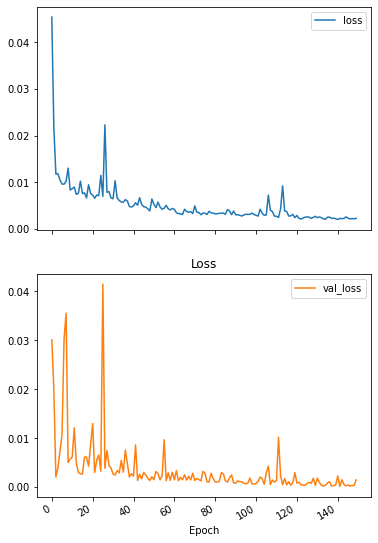

In [7]:
model.loss_render()

# Testing

Loading model complete!!


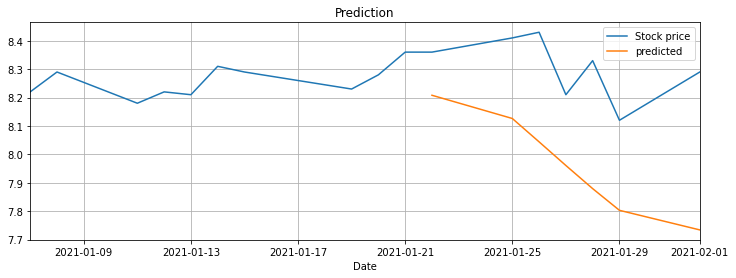

In [8]:
model.testing()

# Absolute Mean Square Error

In [9]:
model.amse()

0.36404441427896256

# Error

In [10]:
prediction = model.true_predictions
true_value = df['Adj Close'].tail(7).values.reshape(-1,1)
print(f'%Error : {np.mean((np.abs(prediction - true_value) / true_value) * 100):.4f} %')

%Error : 4.1187 %
